In [1]:
import numpy as np
from scipy.stats import norm
import statsmodels.stats.api as sms
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (6,3)

# Endowment effect exploration

_In psychology and behavioral economics, the endowment effect is the finding that people are more likely to retain an object they own than acquire that same object when they do not own it._


The task following the gel application required the men to look at photos of 28 items, half of which were considered utilitarian and another one as hedonic. Each product was presented randomly twice during each session (placebo and testosterone), and participants needed to express their value estimation of the item by typing price.
When it was indicated on the photo that they possess an item, participants asked to indicate the minimum amount of money they willing to accept (WTA) to give it up. If it was indicated on the photo that the item possessed by someone else, participants asked to indicate the maximum amount of money they willing to pay (WTP) to acquire it.

The WTA/WTP ratio mesures endowment effect. In this paradigm, willingness to pay (WTP) to acquire an object is typically lower than the least amount they are willing to accept (WTA) to give up that same object when they own it—even when there is no cause for attachment.

The hypotesis to test:
 - There is endowment effect for both type of goods (utilitarian and hedonic), WTA/WTP > 1
 - Endowment effect for hedonic goods bigger then for utilitarian (WTA/WTP)(hedonic) > (WTA/WTP)(utilitarian)
 - Testosterone administration will increase endowment effect, especially for hedonic goods. 

## Hormone data

Testosterone and cortisol serum concentrations were analyzed by electrochemiluminescence immunoassays (ECLIA, Roche® Diagnostics GmbH). For testosterone, the inter-assay coefficient was 2.4 with a lower detection limit of 0.09 nmol/L. Respective inter-assay data for cortisol was 3.8 with a lower detection limit of 0.054 µg/dl. Intra-assay coefficients for testosterone and cortisol were below 3. All analyses were conducted under strict internal and external quality control at the Clinical Chemistry, Haematology, Virology, and Microbiology Laboratory Diagnostic Centre (LDZ) of the RWTH Aachen University Hospital.

In [4]:
#reading hormone data 
df = pd.read_csv('horm_sort.csv', usecols = [0,1,2,3])
df[['Testosterone']]= df[['Testosterone']].apply(pd.to_numeric, errors='coerce')
df.rename(columns={"Subjects": "ID"}, inplace = True)
h_df = df.groupby(['Time','Type','ID'])['Testosterone'].min().unstack().T
h_df.columns = ['Pl_T0','T_T0','Pl_T1','T_T1']
#handling with missing data
h_df.loc['MR24','Pl_T0'] = h_df.loc['MR24','Pl_T1'] 
h_df.loc['MR25','T_T1'] = h_df[h_df['Pl_T0'].between(18, 25)]['T_T1'].mean()
h_df['TPl_change'] = (h_df['T_T1']-h_df['Pl_T1'])/h_df['Pl_T1']
TPl_change = h_df.TPl_change
TPl_change['MR23'] = TPl_change.mean()
#merging with the subject keys and hormone change
ids = pd.read_excel('EE_subj_list.xlsx', header=None, usecols = [1,2])
ids.columns = ['ID', 'Subjects']
ids = ids.join(TPl_change, on = ['ID'])

In [5]:
print('Subject list and corresponding testosterone level change (relative to placebo level state at the moment of task performing)')
ids.head()

Subject list and corresponding testosterone level change (relative to placebo level state at the moment of task performing)


,ID,Subjects,TPl_change
0,MR01,Subj1,2.655172
1,MR02,Subj2,0.491713
2,MR03,Subj3,1.287879
3,MR04,Subj4,0.030303
4,MR05,Subj5,0.416894


## Endowment data

In [6]:
df = pd.read_excel('Endowment_list.xlsx')
df1 = pd.melt(df, id_vars=['Subjects','Item','Type','Market Price'], value_vars=['WTA_Test','WTA_Plac'], value_name='WTA')
df1['Test'] = 0
df1.loc[df1.variable.str.contains('Test'),'Test'] = 1
df1.drop('variable', axis=1, inplace = True)
df2 = pd.melt(df, id_vars=['Subjects','Item','Type','Market Price'], value_vars=['WTP_Test','WTP_Plac'], value_name='WTP')
df2['Test'] = 0
df2.loc[df2.variable.str.contains('Test'),'Test'] = 1
df2.drop('variable', axis=1, inplace = True)
df = df1.merge(df2)
df.drop(df.index[(df.WTA.isin([0, np.nan])) | (df.WTP.isin([0, np.nan]))], inplace = True)
df = pd.merge(df, ids, on = 'Subjects')
df.loc[df.Test==0, 'TPl_change'] = 0
df['WTA/WTP'] = df.WTA/df.WTP
df = df.drop(['Market Price','WTA','WTP','ID'],axis=1)

In [ ]:
#optional: drop individual with inconsistent replies 
df = df[~ df.Subjects.isin(['Subj33'])].reset_index(drop=True)

In [ ]:
#df[df.Subjects.isin(['Subj1'])]
df

There is a number of outliers in the data, where WTA exceeds WTP 20 times and more. We decided to clip these values to a reasonable upper boarder equal to mean value with 3 standart deviations added.

In [8]:
max_rel = df['WTA/WTP'].mean()+3*df['WTA/WTP'].std()
df['WTAPcorr'] = df['WTA/WTP']
df.loc[df['WTA/WTP']>max_rel,'WTAPcorr'] = max_rel

In [9]:
df["ItemCodes"] = pd.Categorical(df['Item']).codes
df["SubjectsCode"] = pd.Categorical(df['Subjects']).codes
df["TypeCode"] = pd.Categorical(df['Type']).codes

In [10]:
df.head()

,Subjects,Item,Type,Test,TPl_change,WTA/WTP,WTAPcorr,ItemCodes,SubjectsCode,TypeCode
0,Subj1,gin,h,1,2.655172,1.000000,1.000000,8,0,0
1,Subj1,beer set,h,1,2.655172,1.500000,1.500000,1,0,0
2,Subj1,video game,h,1,2.655172,1.000000,1.000000,26,0,0
3,Subj1,helicopter,h,1,2.655172,1.333333,1.333333,10,0,0
4,Subj1,car model,h,1,2.655172,1.250000,1.250000,6,0,0


## Endowment effect exploration

1. **For all type of goods**
 
 - H0 : WTA/WTP = 1
 - H1:  WTA/WTP > 1
 
2. **WTA/WTP(hedonic) > WTA/WTP(utilitarian)** 

 - H0 : WTA/WTP(h) =  WTA/WTP(u)
 - H1:  WTA/WTP(h) >  WTA/WTP(u)

In [11]:
import pingouin as pg

### 1. Endowment effect for all type of goods
We tested the first hypothesis with one-sample ttest.  For ttest only placebo data was considered.

In [13]:
pg.ttest(x=df.loc[df.Test==0,'WTA/WTP'],y=1, tail = 'greater')

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,10.883594,1017,greater,1.793211e-26,"[1.34, inf]",0.341113,1.298e+23,1.0


As a result, we can reject H0 very confidently!!! Bayes factor for supporting alternative is extremely high.

### 2. Comparison of hedonic and utilitarian goods

From the picture we can see little difference between hedonic and utilitarian goods

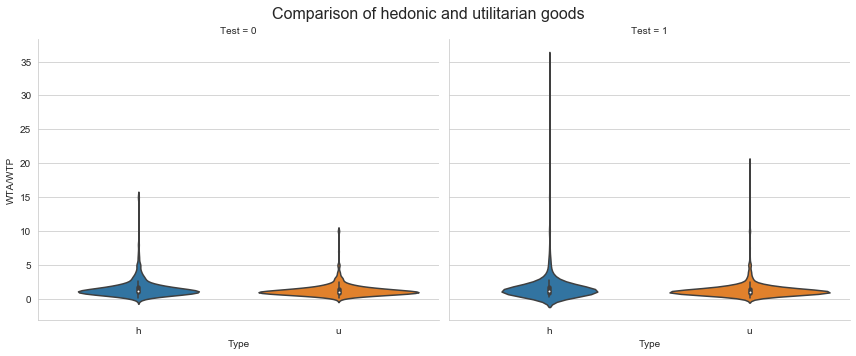

In [15]:
g = sns.catplot(x="Type", y="WTA/WTP",
                col="Test",
                data=df, kind="violin",
                height=5, aspect=1.2);
plt.subplots_adjust(top=0.89)

g.fig.suptitle('Comparison of hedonic and utilitarian goods', size = 16);

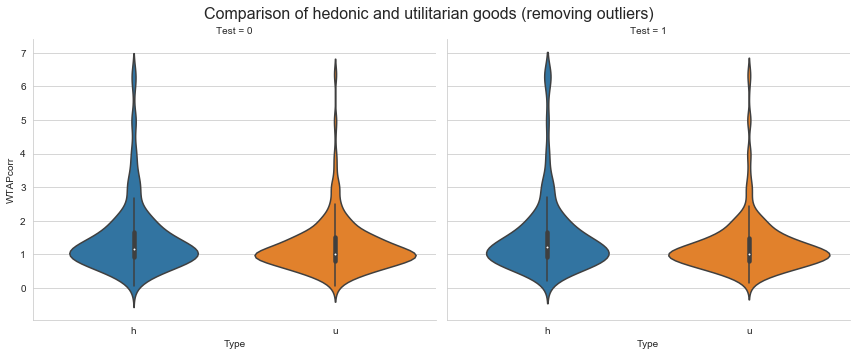

In [16]:
g = sns.catplot(x="Type", y="WTAPcorr",
                col="Test",
                data=df, kind="violin",
                height=5, aspect=1.2);
plt.subplots_adjust(top=0.89)
g.fig.suptitle('Comparison of hedonic and utilitarian goods (removing outliers)', size = 16);

In [17]:
df.groupby(['Type','Test'])['WTA/WTP','WTAPcorr'].agg(['mean','std'])

/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


WTA/WTP            WTAPcorr          
               mean       std      mean       std
Type Test                                        
h    0     1.546391  1.381236  1.504126  1.091903
     1     1.723183  2.489548  1.534656  1.158717
u    0     1.261989  0.927713  1.246495  0.805767
     1     1.310404  1.256742  1.268190  0.860240

There is a small problem with the equal variance assumption here. Equal variance is assumed in both data sets for ttest conduction, but here it is violated.

In [18]:
pg.ttest(x=df.loc[(df.Test == 0)&(df.Type == 'h'),'WTA/WTP'], y=df.loc[(df.Test == 0)&(df.Type == 'u'),'WTA/WTP'], correction=False, tail = 'greater').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.86,1016,greater,0.0,"[0.16, inf]",0.24,205.202,0.99


In [19]:
pg.ttest(x=df.loc[(df.Test == 1)&(df.Type == 'h'),'WTA/WTP'], y=df.loc[(df.Test == 1)&(df.Type == 'u'),'WTA/WTP'], correction=False, tail = 'greater').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.38,1037,greater,0.0,"[0.21, inf]",0.21,37.574,0.96


**Conclusion:**
 - Gathered data proves endowment effect
 - Endowment effect for hedonic goods is greater than for utilitarian ones

### Bayesian perspective

We also used Bayesian perspective for answering the same questions about endowment effect.
Additionally, we can draw posterior distribution for WTA/WTP ratio in general and for each item separately. It is also not sensitive to equal variance assumption. 

Bayseian model: WTA/WTP ratio came from normal distribution with some mean and variance
$$WTA/WTP \sim Normal(\mu,\sigma)$$

Prior suggestion: 
informative prior for checking H0 hypothesis:
mean = 1 
$$\mu \sim (Normal(1, 5))$$

and uniformative prior for sigma
$$\sigma \sim HalfCauchy(10)$$

In [193]:
def effect_size(trace, condition = 'Placebo'):
    means_diff = trace['mean'][:, 0] - trace['mean'][:, 1]
    d_cohen = (means_diff / np.sqrt((trace['sd'][:, 0]**2 +
    trace['sd'][:, 1]**2) / 2)).mean()
    _, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
    az.plot_posterior(means_diff, ref_val=0, ax=ax)
    ax.set_title(f'Difference in WTA/WTP between hedonic and utilitarian goods,\n {condition} condition', size = 16)
    ax.plot(0, label=f"Cohen's d (effect size) = {d_cohen:.2f}",size = 18, alpha=0)
    ax.legend();
def draw_alternative(trace, condition = 'Placebo'):
    _, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)

    az.plot_posterior(trace['mean'][:,0], ax = ax, color = 'orange');
    az.plot_posterior(trace['mean'][:,1], ax = ax, color = 'blue');
    ax.vlines(np.mean(trace['mean'][:,0]), 0,10, 'orange',linestyle='dashed',label=f"mean WTA/WTP hedonic")
    ax.vlines(np.mean(trace['mean'][:,1]), 0,10, 'blue',linestyle='dashed', label=f"mean WTA/WTP utilitarian")
    ax.legend(fontsize=14);
    ax.set_title(f'Posterior distribution of WTA/WTP for hedonic and utilitarian goods\n {condition} condition', size = 16);  
    plt.savefig('imgs/'+ 'diffWTAP.png',format='png', bbox_inches = 'tight')


#### Placebo condition

In [21]:
with pm.Model() as model_pl:
    
    df_sel = df[df.Test==0].reset_index()
    mean = pm.Normal('mean', mu=1, sd=5,  shape=(2,))
    sigma = pm.HalfCauchy('sd', beta=10, shape=(2,))
    WTAP = pm.Normal('WTAP', mu=mean[df_sel['TypeCode'].values], sd=sigma[df_sel['TypeCode'].values], observed=df_sel['WTAPcorr'].values)

    trace_pl = pm.sample(4000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 18000/18000 [00:04<00:00, 3803.98draws/s]


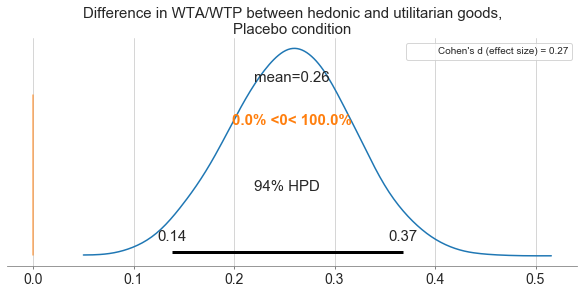

In [22]:
effect_size(trace_pl, condition = 'Placebo') 

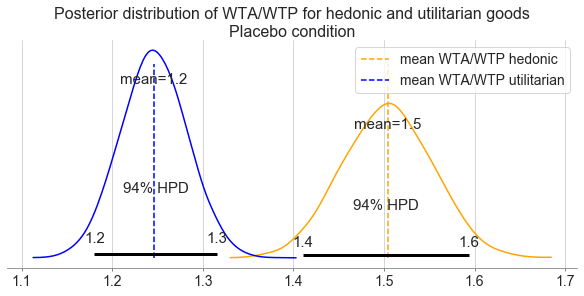

In [194]:
draw_alternative(trace_pl, condition = 'Placebo')

There is a difference, the effect size is medium.

#### Under testosterone
The same, but under testosterone administration

In [29]:
with pm.Model() as model_test:
    
    df_sel = df[df.Test==1].reset_index()
    mean = pm.Normal('mean', mu=0, sd=5,  shape=(2,))
    sigma = pm.HalfCauchy('sd', beta=10, shape=(2,))
    WTAP = pm.Normal('WTAP', mu=mean[df_sel['TypeCode'].values], sd=sigma[df_sel['TypeCode'].values], observed=df_sel['WTAPcorr'].values)

    trace_test = pm.sample(4000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 20000/20000 [00:05<00:00, 3409.82draws/s]


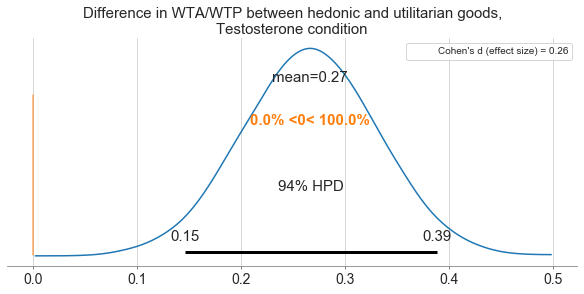

In [30]:
effect_size(trace_test, condition = 'Testosterone')    

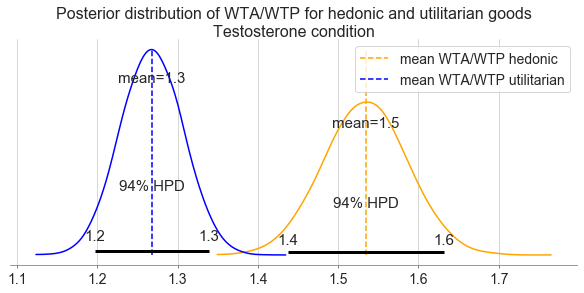

In [79]:
draw_alternative(trace_test, condition = 'Testosterone')

The similar effect for both conitions: testosterone and placebo

### Endowment effect for separate items




Additionally, we can explore the value of endowment effect for each item. Photos of items: https://osf.io/8ubk3/

**Model**

 - WTA/WTP relationship is individual for each item and described with Normal distribution with the following parameters  
 $$WTA/WTP_{item} \sim Normal(\mu_{item},\sigma_{item})$$
 with priors for each item, here 2-level model, we assume that there is general distribution for WTA/WTP and individual values inherited from it: 
 $$\mu  \sim Normal(1, 5), \mu_{item} \sim Normal(mu, 5), sigma_{item} \sim HalfCauchy(0,1)$$
 

In [32]:
n_items = len(pd.unique(df.ItemCodes))
n_inds = len(pd.unique(df.SubjectsCode))
with pm.Model() as model0_item:  
   
    mu  = pm.Normal('mu', 1, 5)

    mu_item  = pm.Normal('mu_item', mu = mu, sd = 5, shape = n_items)
    sigma = pm.HalfCauchy('sigma', beta = 1, shape = n_items)
    
    WTAP = pm.Normal('WTAP', mu=mu_item[df.ItemCodes.values], sd=sigma[df.ItemCodes.values], observed=df['WTAPcorr'].values)
    trace0_item = pm.sample(2000, tune=500, init= 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 2,816.9:   8%|▊         | 15299/200000 [00:08<01:47, 1721.82it/s]
Convergence achieved at 15300
Interrupted at 15,299 [7%]: Average Loss = 3,243.2
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_item, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:05<00:00, 1808.11draws/s]


In [33]:
az.waic(trace0_item)

/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 6000 by 2057 log-likelihood matrix

          Estimate       SE
elpd_waic -2735.30    77.43
p_waic      143.63        -

There has been a warning during the calculation. Please check the results.

In [200]:
def plot_bars(df, name_coeff = 'mu_item', trace = trace0_item, xlim = [0.8,2.5], 
              tname = 'WTA/WTP values and CI for ', label = 'WTA=WTP', x_line = None, xlabel = 'WTA/WTP ratio',save_name = 'WTAPitems'):
    #x_line = trace['mu'].mean()
    coeff = trace[name_coeff]
    coeff_hpd = pm.hpd(coeff)
    res_df = pd.DataFrame(df.groupby(['Item'])['ItemCodes'].min()).reset_index()
    res_df[name_coeff] = coeff.mean(0)
    res_df[name_coeff+'_low'] = coeff_hpd.T[0]
    res_df[name_coeff+'_up'] = coeff_hpd.T[1]
    type_df = pd.DataFrame(df.groupby('Item')['Type'].min()).reset_index()
    res_df = pd.merge(res_df,type_df)
    list_items = [res_df[res_df.Type == 'h'].reset_index(drop=True), res_df[res_df.Type == 'u'].reset_index(drop=True)]
    fig, ax  = plt.subplots(ncols=2, figsize=(16,6))
    cols = ['orange','blue']
    for i in range(2):
        idx = np.argsort(list_items[i][name_coeff])
        y_label = list_items[i].loc[idx,'Item']
        y_points = np.linspace(0, 1, len(idx))
        x = list_items[i].loc[idx,name_coeff].values
        xerr = np.abs(np.array([list_items[i].loc[idx,name_coeff+'_low'].values,list_items[i].loc[idx,name_coeff+'_up'].values])-x)
        ax[i].errorbar(x,y_points,xerr = xerr, fmt='C0o', lw=3, alpha=0.5, mfc = 'purple', ecolor = cols[i])
        ax[i].set_yticks(y_points);
        ax[i].set_yticklabels(y_label, size  = 13);
        ax[i].set_xlim(xlim[0],xlim[1])
        ax[i].vlines(x_line, 0, 1, 'grey', label = label);
        ax[i].set_xlabel(xlabel,fontsize=12)
        gtype = ['hedonic', 'utilitarian']
        ax[i].legend(fontsize=12)
        ax[i].set_title(f'{tname}{gtype[i]} goods', fontsize = 18,fontweight='bold',pad=20)
        plt.subplots_adjust(wspace = 0.3, top = 0.95)

        
        plt.savefig('imgs/'+ save_name+'.png',format='png', bbox_inches = 'tight')


In [198]:
#?plt.subplots_adjust

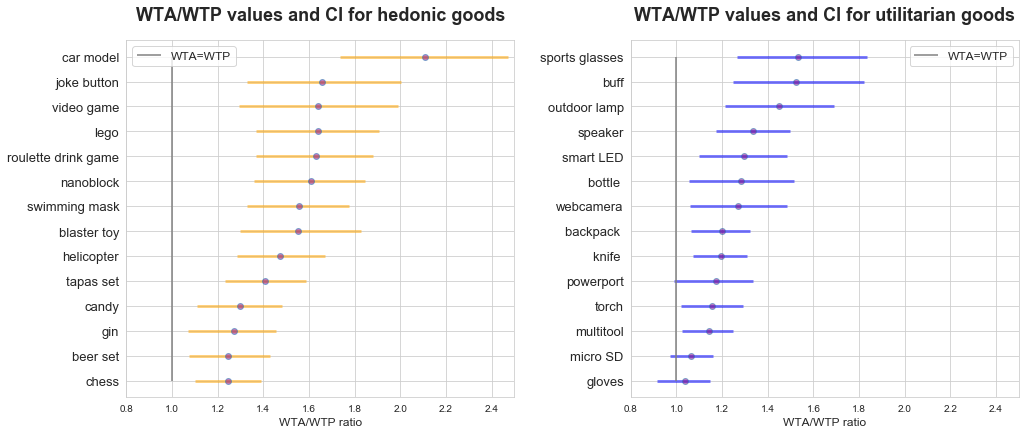

In [201]:
plot_bars(df, name_coeff = 'mu_item', trace = trace0_item, x_line = 1)

**Conclusion:**
What we can conclude: for utilitarian goods assotiated with leisure the endowment effect is greater? 

## Testosterone related shift exploration
We can test the existence of testosterone shift with the paired t-test, 
 - H0  - WTA/WTP(Placebo) = WTA/WTP(Testosterone)
 - H1  - WTA/WTP(Placebo) != WTA/WTP(Testosterone)

In [169]:
df.head()

,Subjects,Item,Type,Test,TPl_change,WTA/WTP,WTAPcorr,ItemCodes,SubjectsCode,TypeCode
0,Subj1,gin,h,1,2.655172,1.000000,1.000000,8,0,0
1,Subj1,beer set,h,1,2.655172,1.500000,1.500000,1,0,0
2,Subj1,video game,h,1,2.655172,1.000000,1.000000,26,0,0
3,Subj1,helicopter,h,1,2.655172,1.333333,1.333333,10,0,0
4,Subj1,car model,h,1,2.655172,1.250000,1.250000,6,0,0


In [170]:
df_paired = pd.pivot_table(df, index = ['Subjects'], values = ['WTA/WTP'], columns='Test')
df_paired.columns = ['WTA/WTP_Pl','WTA/WTP_Test']
df_paired.head()

,WTA/WTP_Pl,WTA/WTP_Test
Subjects,,
Subj1,1.491039,1.445810
Subj10,0.994547,1.307143
Subj11,1.264863,1.180910
Subj12,1.917516,2.492512
Subj13,1.105317,1.223567


In [171]:
pg.ttest(x=df_paired['WTA/WTP_Pl'], y=df_paired['WTA/WTP_Test'], paired=True).round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-0.85,37,two-sided,0.4,"[-0.36, 0.15]",0.18,0.245,0.18


**Conclusion** - couldn't reject H0. 

### Bayesian Models

In bayesian approach with the linear model we can take into account item differences and individual differences 

- Model (to report): model with additional testosterone condition, magnitude of change, and individual differences (sigma)):


WTA/WTP relationship is individual for each item and described with Normal distribution with the following parameters:  
 $$WTA/WTP_{item} \sim Normal(\mu_{item},\sigma)$$
  $$\mu_{item} = \mu_{item}(placebo)+bT*Testosterone$$
 with priors for each item, here 2-level model, we assume that there is general distribution for WTA/WTP and individual values inherited from it: 

 $$\mu  \sim Normal(1, 5), \mu_{item} \sim Normal(\mu, 5), bT \sim Normal(0,1)$$
 

$$ \sigma = \sigma_{item}+\sigma_{ind}, \sigma_{item} \sim HalfCauchy(0,1), \sigma_{ind} \sim HalfCauchy(0,1)$$

In [174]:
with pm.Model() as model_3:  
    mu  = pm.Normal('mu', 1, 5)
    #a_ind  = pm.Normal('alpha_ind', 0, sd = 1, shape = n_inds)
    a_item  = pm.Normal('alpha', mu = mu, sd = 5, shape = n_items)
    sigma = pm.HalfCauchy('sigma', beta = 1, shape = n_items)
    bT = pm.Normal('bT', mu = 0, sd = 1, shape = n_items)
    #mu_item  = pm.Deterministic('mu_item', a_ind[df.SubjectsCode.values]+a_item[df.ItemCodes.values]+bT[df.ItemCodes.values]*df.TPl_change.values)
    mu_item  = pm.Deterministic('mu_item', a_item[df.ItemCodes.values]+bT[df.ItemCodes.values]*df.TPl_change.values)
    #mu_item  = pm.Deterministic('mu_item', a_item[df.ItemCodes.values]+bT[df.ItemCodes.values]*df.Test.values)

    sigmaInd = pm.HalfCauchy('sigmaInd', beta = 0.5, shape = n_inds)
    
    WTAP = pm.Normal('WTAP', mu=mu_item, sd=sigma[df.ItemCodes.values]+sigmaInd[df.SubjectsCode.values], observed=df['WTAPcorr'].values)
    trace_3 = pm.sample(2000, tune=500, init= 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 2,686.4:   8%|▊         | 16699/200000 [00:10<01:53, 1608.92it/s]
Convergence achieved at 16700
Interrupted at 16,699 [8%]: Average Loss = 3,010.1
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigmaInd, bT, sigma, alpha, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:12<00:00, 779.70draws/s]
The number of effective samples is smaller than 25% for some parameters.


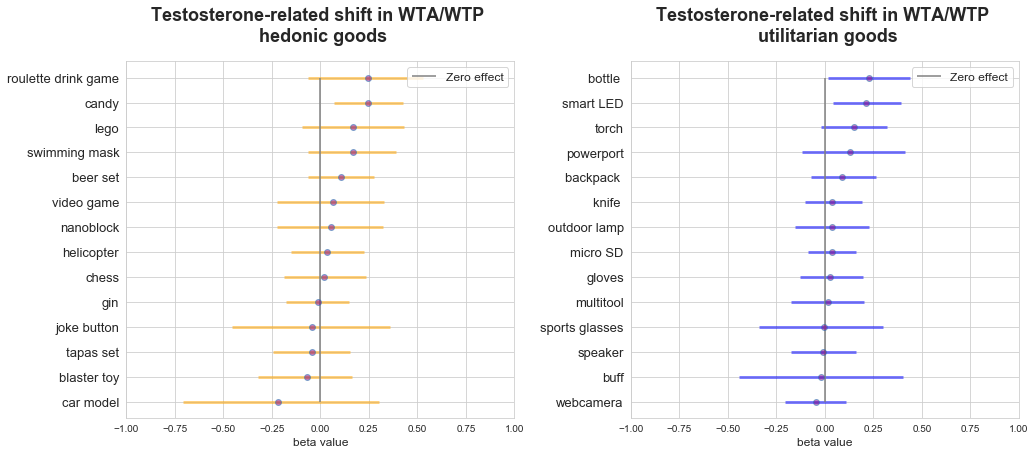

In [202]:
plot_bars(df, name_coeff = 'bT', trace = trace_3, x_line = 0, xlim = [-1,1], 
          tname = 'Testosterone-related shift in WTA/WTP \n ', label = 'Zero effect', xlabel = 'beta value', save_name = 'TestEffect')

In [36]:
with pm.Model() as model_1:  
    
    mu  = pm.Normal('mu', 1, 5)

    a_item  = pm.Normal('alpha', mu = mu, sd = 5, shape = n_items)
    sigma = pm.HalfCauchy('sigma', beta = 1, shape = n_items)
    bT = pm.Normal('bT', mu = 0, sd = 1, shape = n_items)


    mu_item  = pm.Deterministic('mu_item', a_item[df.ItemCodes.values]+bT[df.ItemCodes.values]*df.Test.values)

    
    WTAP = pm.Normal('WTAP', mu=mu_item, sd=sigma[df.ItemCodes.values], observed=df['WTAPcorr'].values)
    trace_1 = pm.sample(2000, tune=500, init= 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 2,862.1:   9%|▊         | 17099/200000 [00:09<01:42, 1784.24it/s]
Convergence achieved at 17100
Interrupted at 17,099 [8%]: Average Loss = 3,319.2
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bT, sigma, alpha, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:11<00:00, 833.73draws/s]


### Supplementary

Estimated models
 - model 0 (baseline model, without testosterone splitting): WTA/WTP relationship is individual for each item and described with Normal distribution with the following  parameters:  
 $$WTA/WTP_{item} \sim Normal(\mu_{item},\sigma_{item})$$
 with priors for each item, here 2-level model, we assume that there is general distribution for WTA/WTP and individual values inherited from it: 
 $$\mu  \sim Normal(1, 5), \mu_{item} \sim Normal(mu, 5), sigma_{item} \sim HalfCauchy(0,1)$$
 
 - model 1 (model with additional testosterone condition, binary testosterone value): WTA/WTP relationship is individual for each item and described with Normal distribution with the following  parameters:  
 $$WTA/WTP_{item} \sim Normal(\mu_{item},\sigma_{item})$$
  $$\mu_{item} \sim mu_{item}+bT*Testosterone$$
 with priors for each item, here 2-level model, we assume that there is general distribution for WTA/WTP and individual values inherited from it: 

 $$\mu  \sim Normal(1, 5), \mu_{item} \sim Normal(mu, 5), bT \sim Normal(0,1), \sigma_{item} \sim HalfCauchy(0,1)$$
 
 - model 2 (model with additional testosterone condition, magnitude of change): WTA/WTP relationship is individual for each item and described with Normal distribution with the following parameters:  
 $$WTA/WTP_{item} \sim Normal(\mu_{item},\sigma_{item})$$
  $$\mu_{item} \sim mu_{item}+bT*Testosterone$$
 with priors for each item, here 2-level model, we assume that there is general distribution for WTA/WTP and individual values inherited from it: 

 $$\mu  \sim Normal(1, 5), \mu_{item} \sim Normal(\mu, 5), bT \sim Normal(0,1), \sigma_{item} \sim HalfCauchy(0,1)$$
 


- model 4 (model with additional testosterone condition, magnitude of change, and individual differences (mu and sigma)): WTA/WTP relationship is individual for each item and described with Normal distribution with the following parameters: 
 $$WTA/WTP_{item} \sim Normal(\mu_{item},\sigma)$$
  $$\mu_{item} \sim \mu_{ind}+\mu_{item}+bT*Testosterone$$
 with priors for each item, here 2-level model, we assume that there is general distribution for WTA/WTP and individual values inherited from it: 

 $$\mu  \sim Normal(1, 5), \mu_{item} \sim Normal(\mu, 5), bT \sim Normal(0,1)$$
 

$$ \sigma = \sigma_{item}+\sigma_{ind}, \sigma_{item} \sim HalfCauchy(0,1), \sigma_{ind} \sim HalfCauchy(0,1)$$

In the last model, we assume that there is individual WTA/WTP mean, this is strange, but likelihood became better



In [ ]:
az.waic(trace_1)

In [ ]:
plot_bars(df, name_coeff = 'bT', trace = trace_1, x_line = 0, xlim = [-1,1], tname = 'Testosterone (indicator)-related shift in WTA/WTP ', label = 'Zero shift')

In [ ]:
with pm.Model() as model_2:  
    
    mu  = pm.Normal('mu', 1, 5)
    a_item  = pm.Normal('alpha', mu = mu, sd = 5, shape = n_items)
    sigma = pm.HalfCauchy('sigma', beta = 1, shape = n_items)
    bT = pm.Normal('bT', mu = 0, sd = 1, shape = n_items)
    mu_item  = pm.Deterministic('mu_item', a_item[df.ItemCodes.values]+bT[df.ItemCodes.values]*df.TPl_change.values)
    WTAP = pm.Normal('WTAP', mu=mu_item, sd=sigma[df.ItemCodes.values], observed=df['WTAPcorr'].values)
    trace_2 = pm.sample(2000, tune=500, init= 'advi')[500:]

In [ ]:
az.waic(trace_2)

In [ ]:
plot_bars(df, name_coeff = 'bT', trace = trace_2, x_line = 0, xlim = [-1,1], tname = 'Testosterone (real value)-related shift in WTA/WTP ', label = 'Zero shift')

In [ ]:
az.waic(trace_3)

In [ ]:
plot_bars(df, name_coeff = 'bT', trace = trace_3, x_line = 0, xlim = [-1,1], tname = 'Testosterone (real value)-related shift in WTA/WTP \n with individual differences ', label = 'Zero shift')

In [ ]:
with pm.Model() as model_4:  
    mu  = pm.Normal('mu', 1, 5)
    a_ind  = pm.Normal('alpha_ind', 0, sd = 1, shape = n_inds)
    a_item  = pm.Normal('alpha', mu = mu, sd = 5, shape = n_items)
    sigma = pm.HalfCauchy('sigma', beta = 1, shape = n_items)
    bT = pm.Normal('bT', mu = 0, sd = 1, shape = n_items)
    mu_item  = pm.Deterministic('mu_item', a_ind[df.SubjectsCode.values]+a_item[df.ItemCodes.values]+bT[df.ItemCodes.values]*df.TPl_change.values)

    sigmaInd = pm.HalfCauchy('sigmaInd', beta = 0.5, shape = n_inds)
    
    WTAP = pm.Normal('WTAP', mu=mu_item, sd=sigma[df.ItemCodes.values]+sigmaInd[df.SubjectsCode.values], observed=df['WTAPcorr'].values)
    trace_4 = pm.sample(2000, tune=500, init= 'advi')[500:]

In [ ]:
plot_bars(df, name_coeff = 'bT', trace = trace_4, x_line = 0, xlim = [-1,1], tname = 'Testosterone (real value)-related shift in WTA/WTP \n with individual differences ', label = 'Zero shift')